<class 'torch_geometric.loader.dataloader.DataLoader'>
Data(x=[248, 4], edge_index=[2, 61256]) found in data


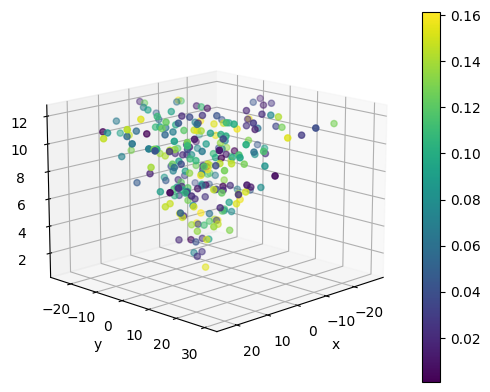

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

def build_edge_index(num_nodes):
    # Initialise the edge index matrix
    edge_matrix = torch.zeros((2, num_nodes*(num_nodes-1)), dtype=torch.long)
    
    # Populate the first row
    for node in range(num_nodes):
        for neighbour in range(num_nodes - 1):
            edge_matrix[0, node*(num_nodes-1)+neighbour] = node
    # Populate the second row
    neighbours = []
    for node in range(num_nodes):
        neighbours.append(list(np.arange(node)) + list(np.arange(node+1,num_nodes)))
    
    edge_matrix[1,:] = torch.tensor([item for sublist in neighbours for item in sublist])
    return edge_matrix
        
n_showers = 1000
nlayer = 12
max_energy = 1000
Event = []
max_hits = 368
hits_energy = torch.rand(n_showers)*max_energy
hits_energy_np = hits_energy.numpy()
for nEvent in range(n_showers):
    hit = []
    remaining_hits = max_hits
    for layer in range(nlayer):
        z = layer + 1
        nhits = torch.randint(low=1, high=z*5, size=(1,))
        energy_dep  = torch.rand((nhits[0],1))*(hits_energy_np[nEvent]/float(max_hits))
        position_xy = torch.randn((nhits[0],2))*z
        position_z  = torch.ones((nhits[0],1))*z
        position    = torch.cat([energy_dep,position_xy, position_z], axis=-1)
        hit.append(position)
        remaining_hits -= nhits
    all_hits = torch.cat(hit, axis=0)
    num_nodes = len(all_hits)
    edge_index = build_edge_index(num_nodes=num_nodes)
    data = Data(x=all_hits, edge_index=edge_index)
    Event.append(data)

    
if not os.path.exists('dataset'):
    os.system("mkdir -p dataset")
torch.save([Event,hits_energy], 'dataset/toy_model.pt')

dataset = torch.load("dataset/toy_model.pt")
loader = DataLoader(dataset)
print(type(loader))

np_list = []
nevent = 1
for key in dataset[0:nevent]:
    print(f'{key[0]} found in data')
    np_list.append((key[0].x.numpy()))
    points = np.concatenate(np_list)
    Energy = points[:,0]
    x      = points[:,1]
    y      = points[:,2]
    z      = points[:,3]
    w      = Energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
img = ax.scatter(x, y, z, c=w/5)
fig.colorbar(img)
ax.view_init(15,45)

In [4]:
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATv2Conv, Linear

class tdsm(nn.Module):
    def __init__(self,inputdim,embeddim,hiddendim,nhead):
        super().__init__()
        self.embed = nn.Linear(inputdim,embeddim)
        self.fcin = nn.Linear(embeddim*inputdim,hiddendim)
        self.fcout = nn.Linear(hiddendim,embeddim)
        self.out = nn.Linear(embeddim,inputdim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout()
        self.attn = nn.MultiheadAttention(embeddim, 8, batch_first=True)
        self.gat1 = GATv2Conv(embeddim, hiddendim, heads=nhead)
    def forward(self,data):
        x = data.x
        edge_idx = data.edge_index
        embedded_x = self.embed(x)
        residual_x = embedded_x.clone()
        torch_attn_out, torch_attn_out_weights = self.attn(embedded_x,embedded_x,embedded_x)
        attn_out = self.gat1(embedded_x, edge_idx)
        #print(f'torch_attn_out: {torch_attn_out.shape}')
        #print(f'attn_out: {attn_out.shape}')
        embedded_x = self.fcin(attn_out)
        embedded_x = self.act(embedded_x)
        embedded_x = self.dropout(embedded_x)
        embedded_x = self.fcout(embedded_x)
        embedded_x = embedded_x + residual_x
        score_output = self.out(embedded_x)
        #print(f'score_output: {score_output.shape}, {type(score_output)}')
        return score_output

def evaluate_model(model, in_showers, eps=1e-5):
    #print(f'Batch: {type(in_showers)} {in_showers}')
    #print(f'num graphs: {in_showers.num_graphs}')
    #print(f'batch vector: {in_showers.batch}')
    showers_in_batch = torch.max(in_showers.batch)
    in_x = in_showers.x
    random_t = torch.rand(1)*(1-eps) + eps
    z = torch.randn_like(in_showers.x)
    perturbed_x = in_showers.x + z
    model_output = model(in_showers)
    loss = (model_output+z)**2
    sum_loss = torch.sum(loss, dim=(0,1))
    mean_batch_loss = sum_loss/showers_in_batch
    return mean_batch_loss

data = dataset[0]
print(f'data: {len(data)}')
incident_e = dataset[1]
loader = DataLoader(dataset[0], batch_size=1, shuffle=True)
n_features = data[0].x.shape[1]
n_heads = 8
embed_dims = 256
hidden_dims = 128
model = tdsm(n_features, embed_dims, hidden_dims, n_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
model.train()
for epoch in range(200):
    for batch in loader:
        losses = evaluate_model(model, batch)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'Epoch loss: {losses}')

data: 1000
score_output: torch.Size([186, 4]), <class 'torch.Tensor'>
score_output: torch.Size([233, 4]), <class 'torch.Tensor'>
score_output: torch.Size([173, 4]), <class 'torch.Tensor'>
score_output: torch.Size([247, 4]), <class 'torch.Tensor'>
score_output: torch.Size([194, 4]), <class 'torch.Tensor'>
score_output: torch.Size([217, 4]), <class 'torch.Tensor'>
score_output: torch.Size([223, 4]), <class 'torch.Tensor'>
score_output: torch.Size([148, 4]), <class 'torch.Tensor'>
score_output: torch.Size([266, 4]), <class 'torch.Tensor'>
score_output: torch.Size([99, 4]), <class 'torch.Tensor'>
score_output: torch.Size([156, 4]), <class 'torch.Tensor'>
score_output: torch.Size([211, 4]), <class 'torch.Tensor'>
score_output: torch.Size([164, 4]), <class 'torch.Tensor'>
score_output: torch.Size([227, 4]), <class 'torch.Tensor'>
score_output: torch.Size([209, 4]), <class 'torch.Tensor'>
score_output: torch.Size([134, 4]), <class 'torch.Tensor'>
score_output: torch.Size([161, 4]), <class 'to

KeyboardInterrupt: 